In [1]:
import sys, phate, itertools, torch
from AAnet_torch import *
from torch import nn, optim
import matplotlib
import seaborn as sns
import javadi
import spams
import torch

In [2]:
from PCHA import PCHA
import numpy as np
import pickle as pkl
import graphtools as gt
import matplotlib.pyplot as plt
import scprep, scipy
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, linregress
from sklearn.decomposition import PCA, NMF
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import pdist, squareform

In [3]:
dat = data.StereoSphereProjection(n_components=3, simplex_radius=2, n_obs=10000, )
sim_data = dat.data
vertices = dat.vertices
phate_op = phate.PHATE(random_state=0, n_components=3, verbose=False, knn=5)
data_phate = phate_op.fit_transform(sim_data)
vertices_phate = phate_op.transform(vertices)

/opt/anaconda3/envs/AAnet-torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/anaconda3/envs/AAnet-torch/lib/python3.8/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


<Axes3D: title={'center': 'Curved tetrahedron'}, xlabel='PHATE1', ylabel='PHATE2', zlabel='PHATE3'>

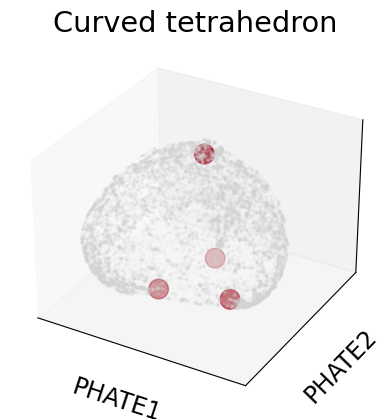

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(data_phate, ax=ax, label_prefix='PHATE', alpha=0.1, title='Curved tetrahedron',
                    azim=90, c='lightgray', fontsize=12, colorbar=False, ticks=None)
scprep.plot.scatter3d(vertices_phate,
                    c='#AC2F3D', ax=ax, s=200)

In [5]:
N_ARCHETYPES = 4

## AAnet

In [6]:
data_loader = torch.utils.data.DataLoader(sim_data, batch_size=256, shuffle=True, num_workers=4)

In [7]:
# Optionally, warm-start model with graph-based extrema

extrema = torch.Tensor(utils.get_laplacian_extrema(sim_data, n_extrema=N_ARCHETYPES))
extrema = torch.Tensor(sim_data[extrema.numpy().astype(int)])

In [8]:
# device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"

print(f"Using device: {device}")
    
model = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                             n_archetypes=N_ARCHETYPES, 
                             input_shape=sim_data.shape[1],
                             device=device, diffusion_extrema=extrema)

optimizer = optim.Adam(model.parameters(), lr=1e-3)



Using device: cpu


### Run AAnet

#### NOTE: This took ~1.5 h to run with `device="cpu"`

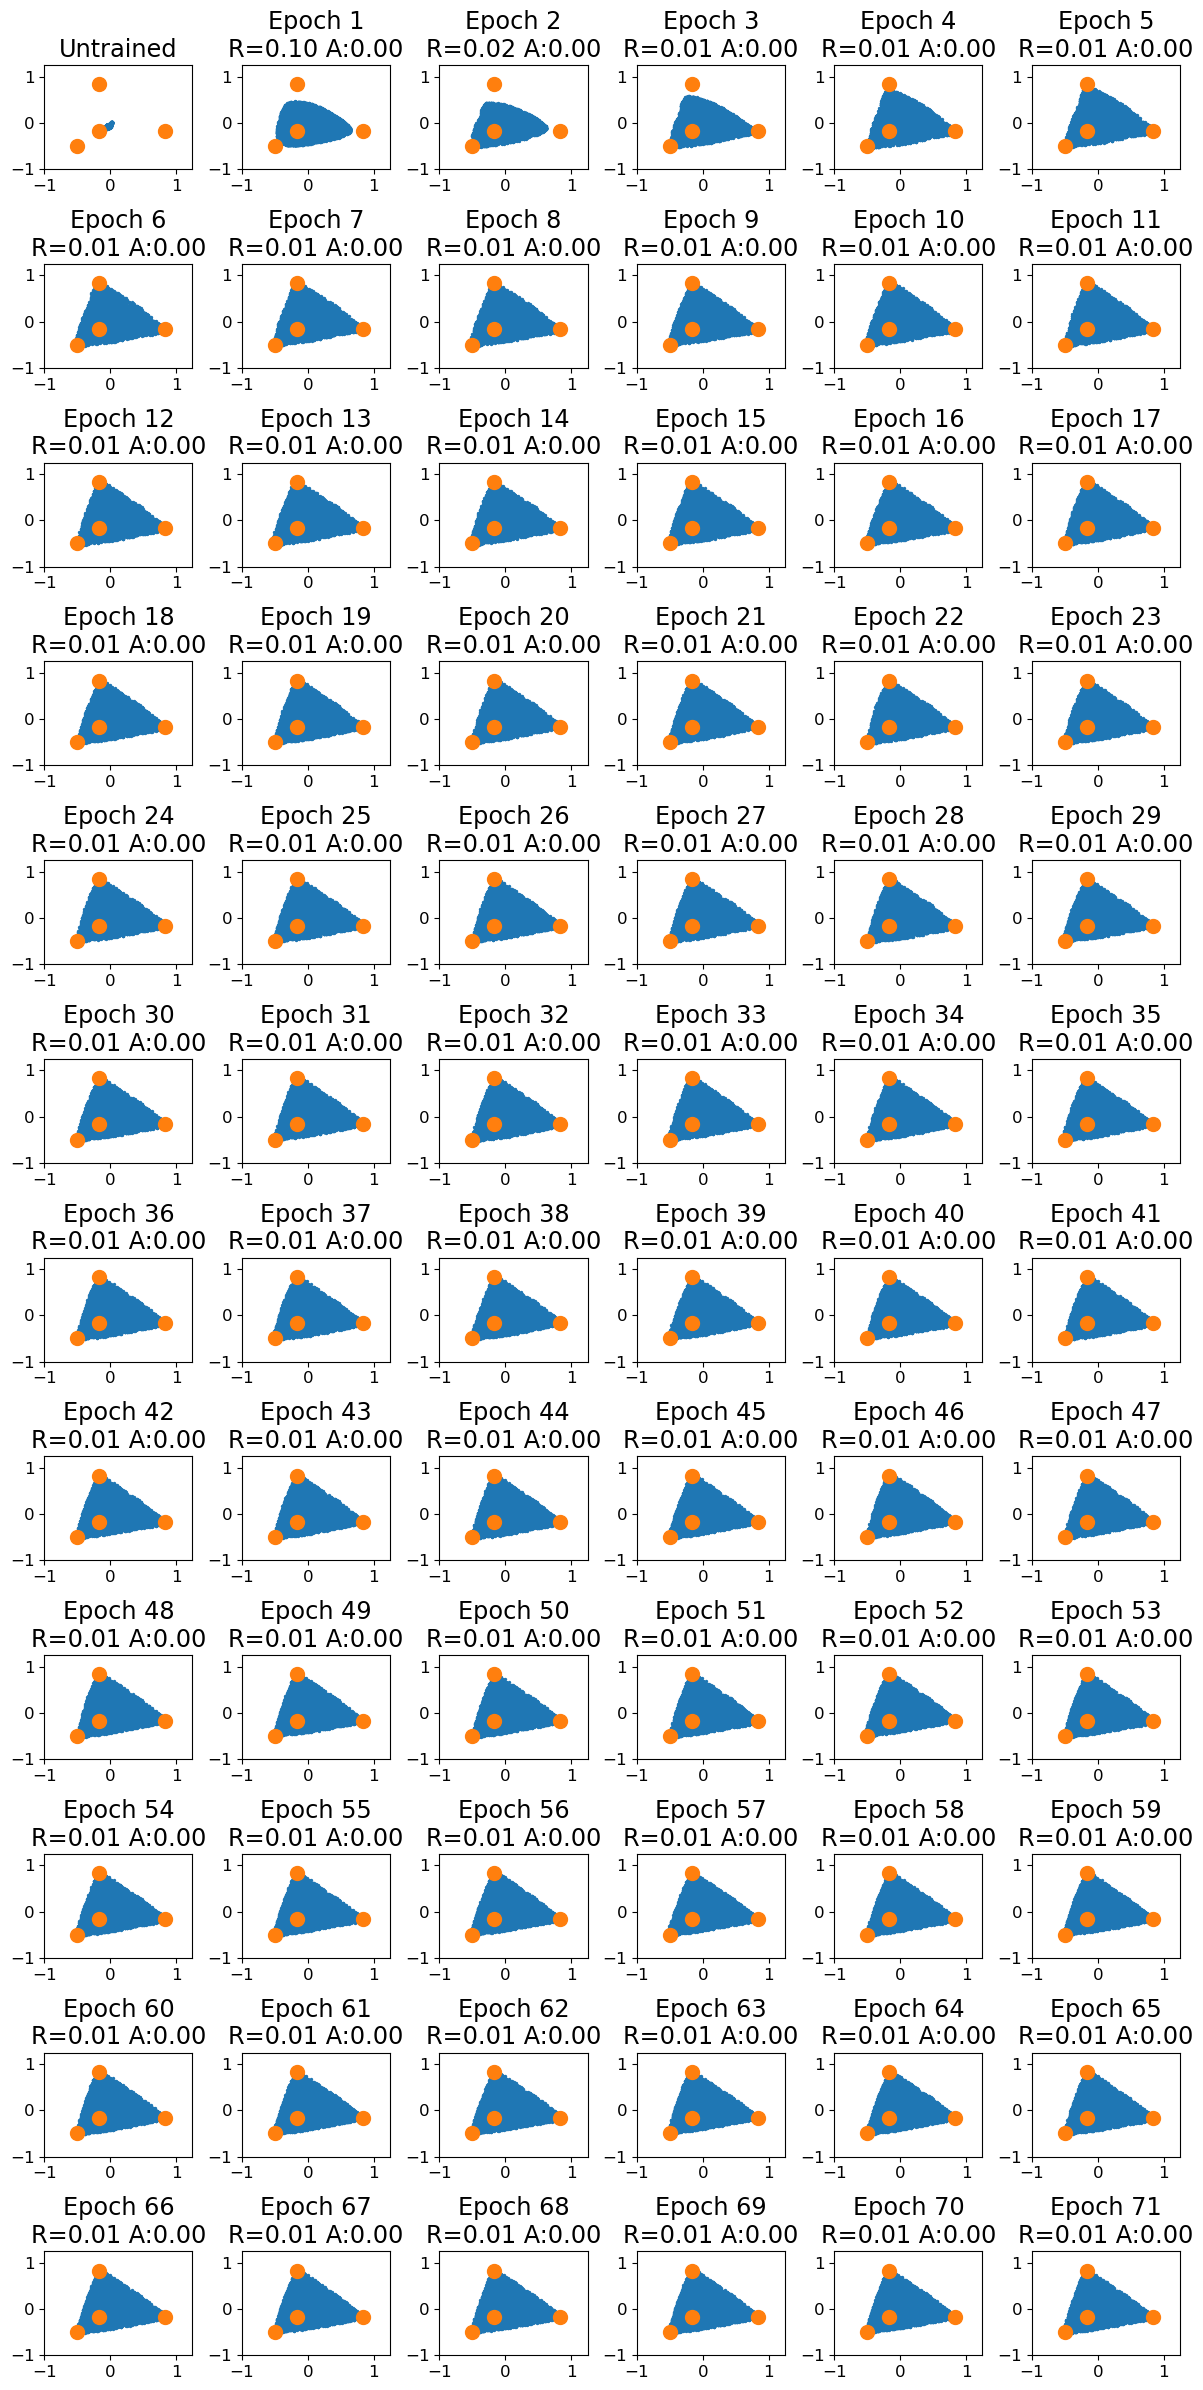

In [9]:
n_row = 12
n_col = 6
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))

for i, ax in enumerate(axes.flatten()):
    if i == 0:
        r_loss = a_loss = 0

        title='Untrained'
    else:
        # gamma_extrema parameter weights how informative graph-based extrema are to model
        # higher gamma_extrema = more pushing AAnet to learn the archetypes learned from the graph-based approach
        loss, r_loss, a_loss=utils.train_epoch(model, data_loader, optimizer, epoch=i, gamma_extrema=0.05)
        title='Epoch {}\nR={:.2f} A:{:.2f}'.format(i, r_loss, a_loss)

    archetypal_embedding = model.encode(torch.Tensor(sim_data))

    scprep.plot.scatter2d(archetypal_embedding.detach().cpu().numpy(), title=title, ax=ax)
    scprep.plot.scatter2d(model.get_n_simplex(model.n_archetypes).cpu().numpy(), ax=ax)
    ax.set_xlim(-1, 1.25)
    ax.set_ylim(-1, 1.25)

fig.tight_layout()

In [10]:
archetypal_embedding = model.encode(torch.Tensor(sim_data))
barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()
aanet_ats = model.decode(model.get_n_simplex(model.n_archetypes).type(torch.float)).cpu().detach().numpy()
aanet_ats_phate = phate_op.transform(aanet_ats)

/opt/anaconda3/envs/AAnet-torch/lib/python3.8/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


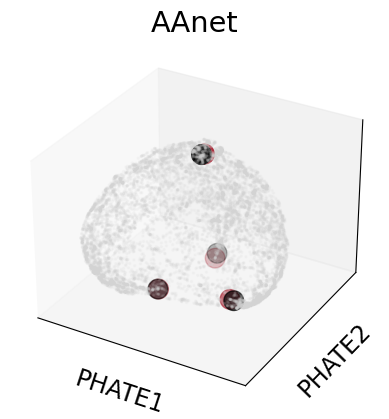

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(data_phate, ax=ax, label_prefix='PHATE', alpha=0.1, title='AAnet',
                    azim=90, c='lightgray', fontsize=12, colorbar=False, ticks=None)
scprep.plot.scatter3d(vertices_phate,
                    c='#AC2F3D', ax=ax, s=200)
scprep.plot.scatter3d(aanet_ats_phate,
                    c='black', ax=ax, s=200)

ax.xaxis.labelpad = 0; ax.yaxis.labelpad = 0; ax.zaxis.labelpad = 0

### Archetypal Score

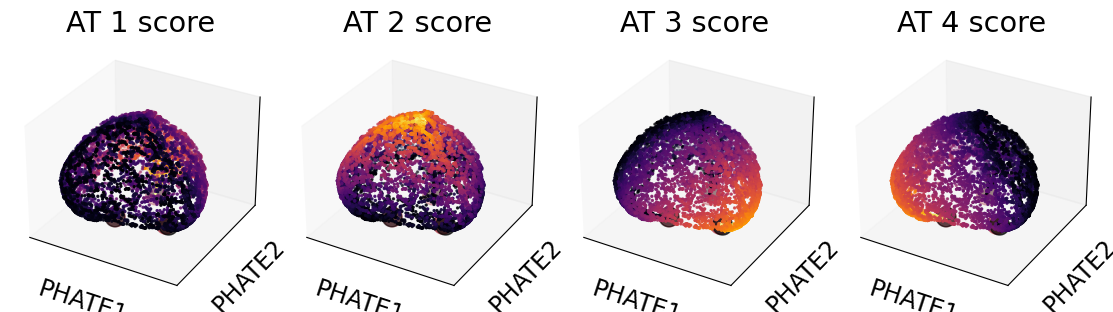

In [12]:
fig = plt.figure(figsize=(14,5))
for i,elem in enumerate([151, 152, 153, 154]):
    ax = fig.add_subplot(elem, projection='3d')
    scprep.plot.scatter3d(data_phate, ax=ax, label_prefix='PHATE', title=f'AT {i+1} score',
                        azim=90, c=barycentric_archetypal_embedding[:, i], fontsize=12, colorbar=False, ticks=None)
    scprep.plot.scatter3d(vertices_phate,
                        c='#AC2F3D', ax=ax, s=200)
    scprep.plot.scatter3d(aanet_ats_phate,
                        c='black', ax=ax, s=200)

    ax.xaxis.labelpad = 0; ax.yaxis.labelpad = 0; ax.zaxis.labelpad = 0
    plt.tight_layout()

## PCHA

In [14]:
XC, S, C, SSE, varexpl = PCHA(sim_data.T, noc=N_ARCHETYPES)
pcha_ats = np.asarray(XC.T)
pcha_ats_phate = phate_op.transform(pcha_ats)

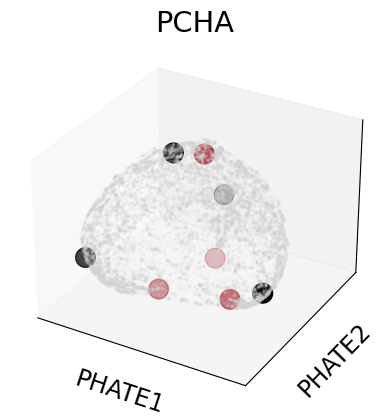

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(data_phate, ax=ax, label_prefix='PHATE', alpha=0.1, title='PCHA',
                    azim=90, c='lightgray', fontsize=12, colorbar=False, ticks=None)
scprep.plot.scatter3d(vertices_phate,
                    c='#AC2F3D', ax=ax, s=200)
scprep.plot.scatter3d(pcha_ats_phate,
                    c='black', ax=ax, s=200)
ax.xaxis.labelpad = 0; ax.yaxis.labelpad = 0; ax.zaxis.labelpad = 0

## Kernel PCHA

In [16]:
D = scipy.spatial.distance.pdist(sim_data)
D = scipy.spatial.distance.squareform(D)
sigma = np.std(D)
K = sim_data @ sim_data.T

In [17]:
_, new_archetypal_coords, C, _, _ = PCHA(K, noc=N_ARCHETYPES)
XC = np.array(sim_data.T @ C).T
kpcha_ats = XC.T
kpcha_ats_phate = phate_op.transform(kpcha_ats)

/opt/anaconda3/envs/AAnet-torch/lib/python3.8/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


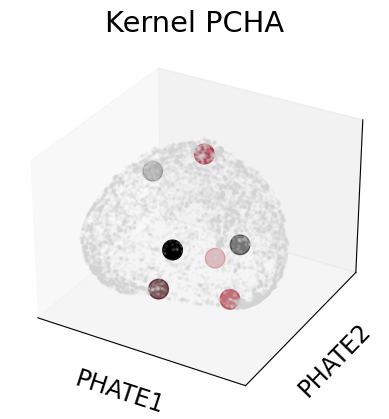

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(data_phate, ax=ax, label_prefix='PHATE', alpha=0.1, title='Kernel PCHA',
                    azim=90, c='lightgray', fontsize=12, colorbar=False, ticks=None)
scprep.plot.scatter3d(vertices_phate,
                    c='#AC2F3D', ax=ax, s=200)
scprep.plot.scatter3d(kpcha_ats_phate,
                    c='black', ax=ax, s=200)

ax.xaxis.labelpad = 0; ax.yaxis.labelpad = 0; ax.zaxis.labelpad = 0

## Javadi et al

In [19]:
new_archetypal_coords, javadi_ats, _, _ = javadi.acc_palm_nmf(sim_data,r=N_ARCHETYPES, maxiter=25, plotloss=False,ploterror=False)
javadi_ats_phate = phate_op.transform(javadi_ats)

/opt/anaconda3/envs/AAnet-torch/lib/python3.8/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


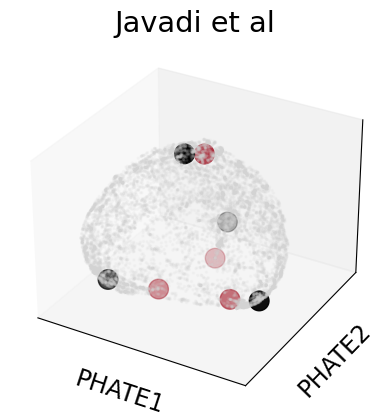

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(data_phate, ax=ax, label_prefix='PHATE', alpha=0.1, title='Javadi et al',
                    azim=90, c='lightgray', fontsize=12, colorbar=False, ticks=None)
scprep.plot.scatter3d(vertices_phate,
                    c='#AC2F3D', ax=ax, s=200)
scprep.plot.scatter3d(javadi_ats_phate,
                    c='black', ax=ax, s=200)

ax.xaxis.labelpad = 0; ax.yaxis.labelpad = 0; ax.zaxis.labelpad = 0

## Chen et al

In [21]:
chen_ats, new_archetypal_coords, _ = spams.archetypalAnalysis(np.asfortranarray(sim_data.T), p=N_ARCHETYPES, returnAB=True, numThreads=-1)
chen_ats = chen_ats.T
chen_ats_phate = phate_op.transform(chen_ats)

RSS FISTA = 2389.0889
RSS FISTA = 1492.5295
RSS FISTA = 1184.1534
RSS AS = 1033.4483
RSS AS = 1008.3099
RSS AS = 1003.1828
RSS AS = 1000.5853
RSS AS = 998.73855
RSS AS = 998.0525
RSS AS = 997.80393
RSS AS = 997.74575
RSS AS = 997.72968
RSS AS = 997.72285
RSS AS = 997.7197
RSS AS = 997.71821
RSS AS = 997.7175
RSS AS = 997.71716
RSS AS = 997.717
RSS AS = 997.71692
RSS AS = 997.71688
RSS AS = 997.71686
RSS AS = 997.71685
RSS AS = 997.71685
RSS AS = 997.71685
RSS AS = 997.71685
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS = 997.71684
RSS AS =

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/AAnet-torch/lib/python3.8/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


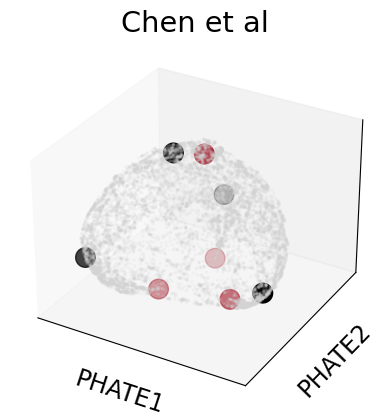

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(data_phate, ax=ax, label_prefix='PHATE', alpha=0.1, title='Chen et al',
                    azim=90, c='lightgray', fontsize=12, colorbar=False, ticks=None)
scprep.plot.scatter3d(vertices_phate,
                    c='#AC2F3D', ax=ax, s=200)
scprep.plot.scatter3d(chen_ats_phate,
                    c='black', ax=ax, s=200)

ax.xaxis.labelpad = 0; ax.yaxis.labelpad = 0; ax.zaxis.labelpad = 0